# N-Body System

In [1]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pylab as p
from scipy.integrate import solve_ivp
import deepdish as dd
import numpy as np
import pandas as pd

In [2]:
def create_param_set_train(num_points, lows, highs):
    a_low, b_low, c_low, d_low = lows
    a_high, b_high, c_high, d_high = highs
    
    params = np.zeros((num_points,4))
    for i in range(num_points):
        a = np.random.uniform(a_low,a_high)
        b = np.random.uniform(b_low,b_high)
        c = np.random.uniform(c_low,c_high)
        d = np.random.uniform(d_low,d_high)
        params[i]=np.array([a,b,c,d])
    return params

def create_param_set_test(num_points, lows, highs, away_min=None, away_max=None):
    a_low, b_low, c_low, d_low = lows
    a_high, b_high, c_high, d_high = highs
    
    params = np.zeros((num_points,4))
    i = 0
    while (i<num_points):
        a = np.random.uniform(a_low-away_max,a_high+away_max)
        b = np.random.uniform(b_low-away_max,b_high+away_max)
        c = np.random.uniform(c_low-away_max,c_high+away_max)
        d = np.random.uniform(d_low-away_max,d_high+away_max)
        
        if not (
                    ((a>=a_low-away_min) and (a<=a_high+away_min))
                and ((b>=b_low-away_min) and (b<=b_high+away_min))
                and ((c>=c_low-away_min) and (c<=c_high+away_min))
                and ((d>=d_low-away_min) and (d<=d_high+away_min))
               ):
            params[i]=np.array([a,b,c,d])
            i+=1
        else:
            pass
#             print(np.round([a,b,c,d],2))
    return params

In [3]:
def ThreeBodyEquations(t, w, K1, K2, m1, m2, m3):
    d = 2
    r1=w[:d]
    r2=w[d:2*d]
    r3=w[2*d:3*d]
    v1=w[3*d:4*d]
    v2=w[4*d:5*d]
    v3=w[5*d:6*d]
    
    r12=np.linalg.norm(r2-r1) # Distance of bodies 1-2
    r13=np.linalg.norm(r3-r1) # Distance of bodies 1-3
    r23=np.linalg.norm(r3-r2) # Distance of bodies 2-3
    
    dv1 = K1 * m2 * (r2-r1) / r12**3 + K1 * m3 * (r3-r1) / r13**3
    dv2 = K1 * m1 * (r1-r2) / r12**3 + K1 * m3 * (r3-r2) / r23**3
    dv3 = K1 * m1 * (r1-r3) / r13**3 + K1 * m2 * (r2-r3) / r23**3
    dr1 = K2 * v1
    dr2 = K2 * v2
    dr3 = K2 * v3

    derivs=np.concatenate((dr1, dr2, dr3, dv1, dv2, dv3))
    return derivs

In [4]:
def create_3body_dataset(datapoints, dt, timesteps, init_state, tol=1e-7):
    t_min = 0.0
    t_max = timesteps*dt
    ts = np.linspace(t_min, t_max, timesteps)

    n_datapoints = len(datapoints)
    print(f'Creating {n_datapoints} datapoints')

    phase_space = np.empty((n_datapoints, timesteps, 6)) # 6 degrees of freedom
    labels = []
    for i,(K2,m1,m2,m3) in enumerate(datapoints):
        if i%50==0:
            print(f'Created {i}/{n_datapoints}')

        sol = solve_ivp(ThreeBodyEquations, [t_min, t_max], init_state, t_eval = ts, 
                            args=(K1, K2, m1, m2, m3), method='DOP853', rtol=tol, atol=tol).y.T

        phase_space[i] = sol[:, :6] # only positions
        labels.append({'dt': dt, 
                       'initial_state': init_state,
                       'params': np.array([K1, K2, m1, m2, m3]),
                       })
    dataset = {'phase_space': phase_space, 'labels': labels}
    return dataset

# PARAMS

In [5]:
# INITIAL POSITIONS in meters
pos_scale=1.0
vel_scale=0.5
r1=np.array([pos_scale*1.0,  pos_scale*-1.0], dtype="float64") # [0.5,0,0]
r2=np.array([pos_scale*-1.0, pos_scale*-1.0], dtype="float64") # [-0.5,0,0]
r3=np.array([pos_scale*0.0,  pos_scale*1.0], dtype="float64") # [0,-0.01,0]

# INITIAL VELOCITIES in m/s
v1=np.array([0*vel_scale, vel_scale], dtype="float64") # [0.01,0.01,0]
v2=np.array([vel_scale, -vel_scale], dtype="float64") # [-0.05,0,-0.1]
v3=np.array([-vel_scale, 0*vel_scale], dtype="float64") # [0,-0.01,0]


init_state=np.array([r1, r2, r3, v1, v2, v3]).flatten()
print(init_state)

[ 1.  -1.  -1.  -1.   0.   1.   0.   0.5  0.5 -0.5 -0.5  0. ]


In [6]:
dt=0.01
timesteps=1000
means=np.array([2.00, 2.00, 2.00, 2.00])
delta=0.10
names = ['K2', 'm1', 'm2', 'm3']
K1 = 1.0
lows = means - delta
highs = means + delta

# TRAIN SET

In [7]:
n_datapoints=10000

datapoints = create_param_set_train(n_datapoints, lows, highs)
train_dset = create_3body_dataset(datapoints, dt, timesteps, init_state, tol=1e-7)

init_str = '_'.join([f'{a:.1f}' for a in init_state])
params_str = '_'.join([f'{names[k]}_{means[k]:.2f}' for k in range(4)])
means_str = '_'.join([f'{a:.1f}' for a in means])
away_str = ''
fname = f'../data/3body_n_{n_datapoints}_steps_{timesteps}_dt_{dt:.2f}_params_{params_str}_delta_{delta:.2f}{away_str}.hd5'
print(fname)

dd.io.save(fname, train_dset)

Creating 10000 datapoints
Created 0/10000
Created 50/10000
Created 100/10000
Created 150/10000
Created 200/10000
Created 250/10000
Created 300/10000
Created 350/10000
Created 400/10000
Created 450/10000
Created 500/10000
Created 550/10000
Created 600/10000
Created 650/10000
Created 700/10000
Created 750/10000
Created 800/10000
Created 850/10000
Created 900/10000
Created 950/10000
Created 1000/10000
Created 1050/10000
Created 1100/10000
Created 1150/10000
Created 1200/10000
Created 1250/10000
Created 1300/10000
Created 1350/10000
Created 1400/10000
Created 1450/10000
Created 1500/10000
Created 1550/10000
Created 1600/10000
Created 1650/10000
Created 1700/10000
Created 1750/10000
Created 1800/10000
Created 1850/10000
Created 1900/10000
Created 1950/10000
Created 2000/10000
Created 2050/10000
Created 2100/10000
Created 2150/10000
Created 2200/10000
Created 2250/10000
Created 2300/10000
Created 2350/10000
Created 2400/10000
Created 2450/10000
Created 2500/10000
Created 2550/10000
Created 2

/home/stathi/miniconda3/envs/cuda10/lib/python3.7/site-packages/deepdish/io/hdf5io.py:251: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


# OOD TEST SET 1

In [8]:
n_datapoints=1000
away_min = 0.00
away_max = 0.02

datapoints = create_param_set_test(n_datapoints, lows, highs, away_min, away_max)
val_dset = create_3body_dataset(datapoints, dt, timesteps, init_state, tol=1e-7)

init_str = '_'.join([f'{a:.1f}' for a in init_state])
params_str = '_'.join([f'{names[k]}_{means[k]:.2f}' for k in range(4)])
means_str = '_'.join([f'{a:.1f}' for a in means])
away_str = '' if away_min is None else f'_away_{away_min:.2f}_{away_max:.2f}'
fname = f'../data/3body_n_{n_datapoints}_steps_{timesteps}_dt_{dt:.2f}_params_{params_str}_delta_{delta:.2f}{away_str}.hd5'
print(fname)

dd.io.save(fname, val_dset)

Creating 1000 datapoints
Created 0/1000
Created 50/1000
Created 100/1000
Created 150/1000
Created 200/1000
Created 250/1000
Created 300/1000
Created 350/1000
Created 400/1000
Created 450/1000
Created 500/1000
Created 550/1000
Created 600/1000
Created 650/1000
Created 700/1000
Created 750/1000
Created 800/1000
Created 850/1000
Created 900/1000
Created 950/1000
../data/3body_n_1000_steps_1000_dt_0.01_params_K2_2.00_m1_2.00_m2_2.00_m3_2.00_delta_0.10_away_0.00_0.02.hd5


# OOD TEST SET 2

In [9]:
n_datapoints=1000
away_min = 0.02
away_max = 0.05

datapoints = create_param_set_test(n_datapoints, lows, highs, away_min, away_max)
test_dset = create_3body_dataset(datapoints, dt, timesteps, init_state, tol=1e-7)

init_str = '_'.join([f'{a:.1f}' for a in init_state])
params_str = '_'.join([f'{names[k]}_{means[k]:.2f}' for k in range(4)])
means_str = '_'.join([f'{a:.1f}' for a in means])
away_str = '' if away_min is None else f'_away_{away_min:.2f}_{away_max:.2f}'
fname = f'../data/3body_n_{n_datapoints}_steps_{timesteps}_dt_{dt:.2f}_params_{params_str}_delta_{delta:.2f}{away_str}.hd5'
print(fname)

dd.io.save(fname, test_dset)

Creating 1000 datapoints
Created 0/1000
Created 50/1000
Created 100/1000
Created 150/1000
Created 200/1000
Created 250/1000
Created 300/1000
Created 350/1000
Created 400/1000
Created 450/1000
Created 500/1000
Created 550/1000
Created 600/1000
Created 650/1000
Created 700/1000
Created 750/1000
Created 800/1000
Created 850/1000
Created 900/1000
Created 950/1000
../data/3body_n_1000_steps_1000_dt_0.01_params_K2_2.00_m1_2.00_m2_2.00_m3_2.00_delta_0.10_away_0.02_0.05.hd5


# VISUALIZE

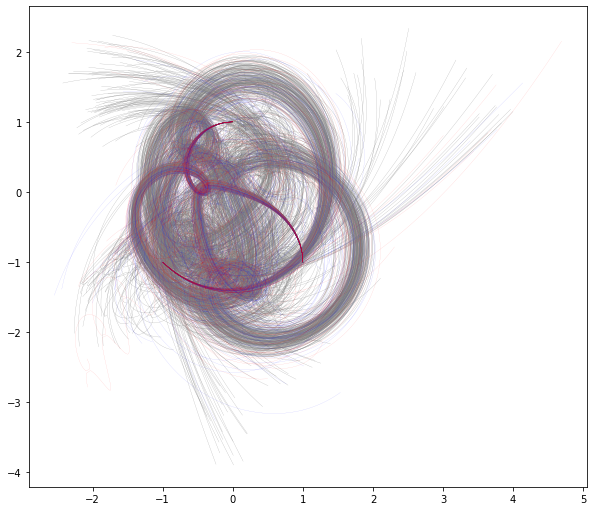

In [10]:
freq=50
mrol=1000
fig=p.figure(figsize=(10,10))
fig.gca().set_aspect('equal')
for i, traj in enumerate(train_dset['phase_space']):
    if i % freq == 0:
        for k in [0,2,4]:
            foxes, rabbits = traj[:mrol,k], traj[:mrol,k+1]
            p.plot(foxes, rabbits, 'gray', alpha=.8, linewidth=0.2)
for i, traj in enumerate(val_dset['phase_space']):
    if i % freq == 0:
        for k in [0,2,4]:
            foxes, rabbits = traj[:mrol,k], traj[:mrol,k+1]
            p.plot(foxes, rabbits, 'b', alpha=.5, linewidth=0.1)
for i, traj in enumerate(test_dset['phase_space']):
    if i % freq == 0:
        for k in [0,2,4]:
            foxes, rabbits = traj[:mrol,k], traj[:mrol,k+1]
            p.plot(foxes, rabbits, 'r', alpha=.5, linewidth=0.1)
p.show()
p.close()

In [138]:
def plot_3body(sol, title=''):
    d = 2
    r1_sol=sol[:,:d]
    r2_sol=sol[:,d:2*d]
    r3_sol=sol[:,2*d:3*d]

    #Create figure
    fig=plt.figure(figsize=(10,10))
    #Create 3D axes
    ax=fig.add_subplot(111)
    ax.set_aspect('equal')
    #Plot the orbits
    ax.plot(r1_sol[:,0],r1_sol[:,1],color="tab:red")
    ax.plot(r2_sol[:,0],r2_sol[:,1],color="tab:green")
    ax.plot(r3_sol[:,0],r3_sol[:,1],color="darkblue")

    #Plot the initial positions of the stars
    ax.scatter(r1_sol[0,0],r1_sol[0,1],color="tab:red",marker="s",s=100,label="B")
    ax.scatter(r2_sol[0,0],r2_sol[0,1],color="tab:green",marker="s",s=100,label="C")
    ax.scatter(r3_sol[0,0],r3_sol[0,1],color="darkblue",marker="s",s=100,label="A")

    #Plot the final positions of the stars
    ax.scatter(r1_sol[-1,0],r1_sol[-1,1],color="tab:red",marker="o",s=100,label="A")
    ax.scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:green",marker="o",s=100,label="B")
    ax.scatter(r3_sol[-1,0],r3_sol[-1,1],color="darkblue",marker="o",s=100,label="C")
    ax.set_ylim([-5,5])
    ax.set_xlim([-5,5])
    plt.title(title)